In [69]:
# Core
import numpy as np
import matplotlib.pyplot as plt

# Geo
import rasterio
from rasterio.warp import reproject, Resampling

# ML
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Utils
import os
from tqdm import tqdm


In [70]:
# Load 2017 RGB
with rasterio.open("bengaluru_2017_rgb.tif") as src:
    img_2017 = np.transpose(src.read([1,2,3]), (1,2,0))
    rgb_transform = src.transform
    rgb_crs = src.crs

# Load 2024 RGB
with rasterio.open("bengaluru_2024_rgb.tif") as src:
    img_2024 = np.transpose(src.read([1,2,3]), (1,2,0))

# Load NDVI-based refined change mask
with rasterio.open("bengaluru_change_mask_refined.tif") as src:
    mask = src.read(1)
    mask_transform = src.transform
    mask_crs = src.crs


In [71]:
print(img_2017.shape)
print(img_2024.shape)
print(mask.shape)
print(np.unique(mask))


(1392, 1671, 3)
(929, 1115, 3)
(1392, 1671)
[0 1]


In [72]:
def normalize(img):
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min())

img_2017 = normalize(img_2017)
img_2024 = normalize(img_2024)


In [73]:
PATCH = 256
stride = 256

tiles = []

H, W, _ = img_2017.shape

for y in range(0, H - PATCH + 1, stride):
    for x in range(0, W - PATCH + 1, stride):

        p17 = img_2017[y:y+PATCH, x:x+PATCH]
        p24 = img_2024[y:y+PATCH, x:x+PATCH]
        m   = mask[y:y+PATCH, x:x+PATCH]

        # HARD guarantees
        if (
            p17.shape == (PATCH, PATCH, 3)
            and p24.shape == (PATCH, PATCH, 3)
            and m.shape  == (PATCH, PATCH)
        ):
            tiles.append((p17, p24, m))

print("Total tiles:", len(tiles))


Total tiles: 12


In [74]:
np.random.shuffle(tiles)
split = int(0.8 * len(tiles))

train_tiles = tiles[:split]
val_tiles   = tiles[split:]


In [75]:
import numpy as np, os

np.random.shuffle(tiles)
split = int(0.8 * len(tiles))

train_tiles = tiles[:split]
val_tiles   = tiles[split:]

for split_name, split_tiles in [("train", train_tiles), ("val", val_tiles)]:
    for sub in ["img_2017", "img_2024", "mask"]:
        os.makedirs(f"dataset/{split_name}/{sub}", exist_ok=True)

    for i, (p17, p24, m) in enumerate(split_tiles):
        np.save(f"dataset/{split_name}/img_2017/{i}.npy", p17)
        np.save(f"dataset/{split_name}/img_2024/{i}.npy", p24)
        np.save(f"dataset/{split_name}/mask/{i}.npy", m)


In [76]:
class ChangeDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.ids = sorted(os.listdir(f"{root}/img_2017"))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        x1 = np.load(f"{self.root}/img_2017/{idx}.npy")
        x2 = np.load(f"{self.root}/img_2024/{idx}.npy")
        y  = np.load(f"{self.root}/mask/{idx}.npy")

        # FINAL SAFETY NET
        if x1.shape != (256,256,3) or x2.shape != (256,256,3) or y.shape != (256,256):
            raise ValueError(f"Corrupt tile at index {idx}: {x1.shape}, {x2.shape}, {y.shape}")

        x1 = torch.tensor(x1).permute(2,0,1).float()
        x2 = torch.tensor(x2).permute(2,0,1).float()
        y  = torch.tensor(y).unsqueeze(0).float()

        return x1, x2, y


In [77]:
train_loader = DataLoader(ChangeDataset("dataset/train"), batch_size=4, shuffle=True)

x1, x2, y = next(iter(train_loader))
print(x1.shape, x2.shape, y.shape)


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])


In [78]:
print(x1.shape, x2.shape, y.shape)


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])


In [79]:
train_loader = DataLoader(
    ChangeDataset("dataset/train"),
    batch_size=4,
    shuffle=True
)

In [80]:
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()

        def encoder():
            return nn.Sequential(
                nn.Conv2d(3, 16, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 32, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )

        self.enc1 = encoder()
        self.enc2 = encoder()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        f1 = self.enc1(x1)
        f2 = self.enc2(x2)
        x  = torch.cat([f1, f2], dim=1)
        return self.decoder(x)


In [81]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SiameseNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(ChangeDataset("dataset/train"), batch_size=4, shuffle=True)


In [82]:
import numpy as np
import os

mask_dir = "dataset/train/mask"

ratios = []
for f in os.listdir(mask_dir):
    m = np.load(os.path.join(mask_dir, f))
    ratios.append(m.mean())

print("Min change ratio:", np.min(ratios))
print("Max change ratio:", np.max(ratios))
print("Mean change ratio:", np.mean(ratios))


Min change ratio: 0.0206298828125
Max change ratio: 0.0764312744140625
Mean change ratio: 0.04564242892795139


In [84]:
import torch.nn as nn
import torch.nn.functional as F

bce = nn.BCELoss()

def dice_loss(pred, target, smooth=1e-6):
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    intersection = (pred * target).sum(dim=1)
    union = pred.sum(dim=1) + target.sum(dim=1)

    return 1 - ((2 * intersection + smooth) / (union + smooth)).mean()

def total_loss(pred, target):
    return bce(pred, target) + dice_loss(pred, target)


In [85]:
EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    running = 0

    for x1, x2, y in train_loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(x1, x2)
        loss = total_loss(pred, y)
        loss.backward()
        optimizer.step()

        running += loss.item()

    print(f"Epoch {epoch+1:02d} | Train Loss: {running/len(train_loader):.4f}")


Epoch 01 | Train Loss: 1.7107
Epoch 02 | Train Loss: 1.6877
Epoch 03 | Train Loss: 1.6973
Epoch 04 | Train Loss: 1.6754
Epoch 05 | Train Loss: 1.6505
Epoch 06 | Train Loss: 1.6179
Epoch 07 | Train Loss: 1.5742
Epoch 08 | Train Loss: 1.5069
Epoch 09 | Train Loss: 1.4320
Epoch 10 | Train Loss: 1.3347
Epoch 11 | Train Loss: 1.2411
Epoch 12 | Train Loss: 1.1535
Epoch 13 | Train Loss: 1.1289
Epoch 14 | Train Loss: 1.1474
Epoch 15 | Train Loss: 1.1832
Epoch 16 | Train Loss: 1.1672
Epoch 17 | Train Loss: 1.1458
Epoch 18 | Train Loss: 1.1260
Epoch 19 | Train Loss: 1.1164
Epoch 20 | Train Loss: 1.1244
Epoch 21 | Train Loss: 1.1174
Epoch 22 | Train Loss: 1.1384
Epoch 23 | Train Loss: 1.1248
Epoch 24 | Train Loss: 1.1368
Epoch 25 | Train Loss: 1.1363
Epoch 26 | Train Loss: 1.1177
Epoch 27 | Train Loss: 1.1340
Epoch 28 | Train Loss: 1.1269
Epoch 29 | Train Loss: 1.1206
Epoch 30 | Train Loss: 1.1336


In [86]:
torch.save(model.state_dict(), "siamese_change_model.pth")


In [87]:
model.eval()
with torch.no_grad():
    p = model(x1, x2)

print(
    "min:", p.min().item(),
    "max:", p.max().item(),
    "mean:", p.mean().item()
)


min: 0.02719026617705822 max: 0.1775132268667221 mean: 0.08124041557312012


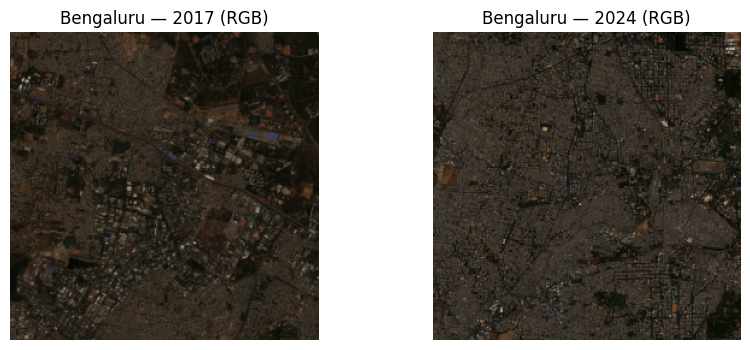

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Bengaluru — 2017 (RGB)")
plt.imshow(img_2017)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Bengaluru — 2024 (RGB)")
plt.imshow(img_2024)
plt.axis("off")

plt.show()


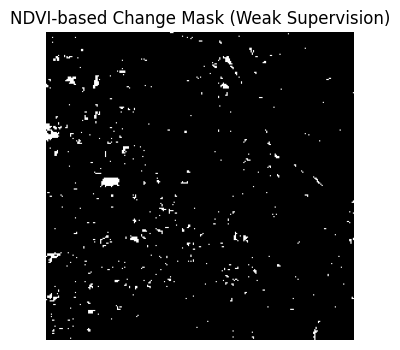

In [ ]:
plt.figure(figsize=(4,4))
plt.title("NDVI-based Change Mask (Weak Supervision)")
plt.imshow(y, cmap="gray")
plt.axis("off")
plt.show()

In [89]:
THRESH = 0.1

pred_flat = (p.detach().cpu().numpy().reshape(-1) > THRESH).astype(int)
y_flat = y.detach().cpu().numpy().reshape(-1)

from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(y_flat, pred_flat, zero_division=0))
print("Recall:", recall_score(y_flat, pred_flat, zero_division=0))
print("F1:", f1_score(y_flat, pred_flat, zero_division=0))

intersection = ((pred_flat == 1) & (y_flat == 1)).sum()
union = ((pred_flat == 1) | (y_flat == 1)).sum()
print("IoU:", intersection / (union + 1e-6))


Precision: 0.06283220944069813
Recall: 0.18635294117647058
F1: 0.09397804805695639
IoU: 0.04930585818033332


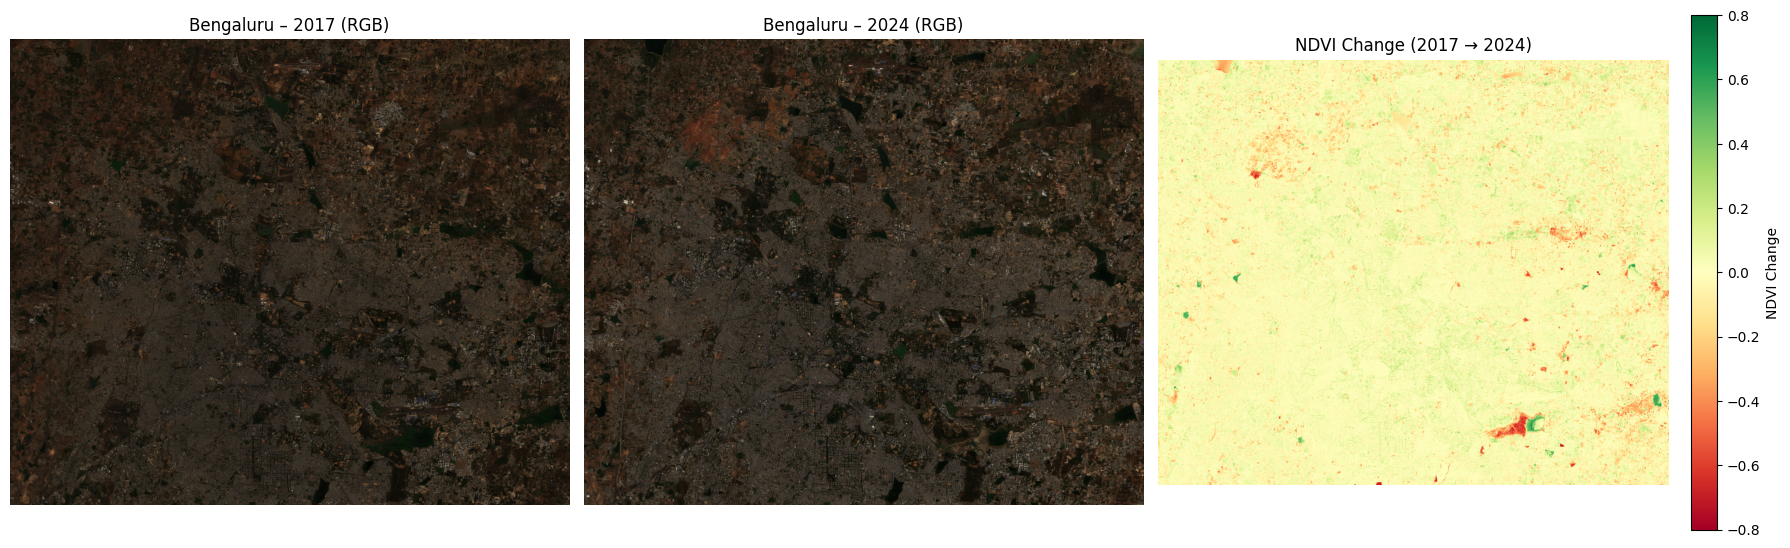

In [94]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load RGB 2017
# -----------------------------
with rasterio.open("bengaluru_2017_rgb.tif") as src:
    rgb_2017 = np.transpose(src.read([1, 2, 3]), (1, 2, 0))

# Normalize for display
rgb_2017 = (rgb_2017 - rgb_2017.min()) / (rgb_2017.max() - rgb_2017.min())

# -----------------------------
# Load RGB 2024
# -----------------------------
with rasterio.open("bengaluru_2024_rgb.tif") as src:
    rgb_2024 = np.transpose(src.read([1, 2, 3]), (1, 2, 0))

rgb_2024 = (rgb_2024 - rgb_2024.min()) / (rgb_2024.max() - rgb_2024.min())

# -----------------------------
# Load NDVI change
# -----------------------------
with rasterio.open("bengaluru_ndvi_change.tif") as src:
    ndvi_change = src.read(1)

# -----------------------------
# Plot
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 2017 RGB
axes[0].imshow(rgb_2017)
axes[0].set_title("Bengaluru – 2017 (RGB)")
axes[0].axis("off")

# 2024 RGB
axes[1].imshow(rgb_2024)
axes[1].set_title("Bengaluru – 2024 (RGB)")
axes[1].axis("off")

# NDVI Change
im = axes[2].imshow(
    ndvi_change,
    cmap="RdYlGn",
    vmin=-0.8,
    vmax=0.8
)
axes[2].set_title("NDVI Change (2017 → 2024)")
axes[2].axis("off")

cbar = plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
cbar.set_label("NDVI Change")

plt.tight_layout()
plt.show()


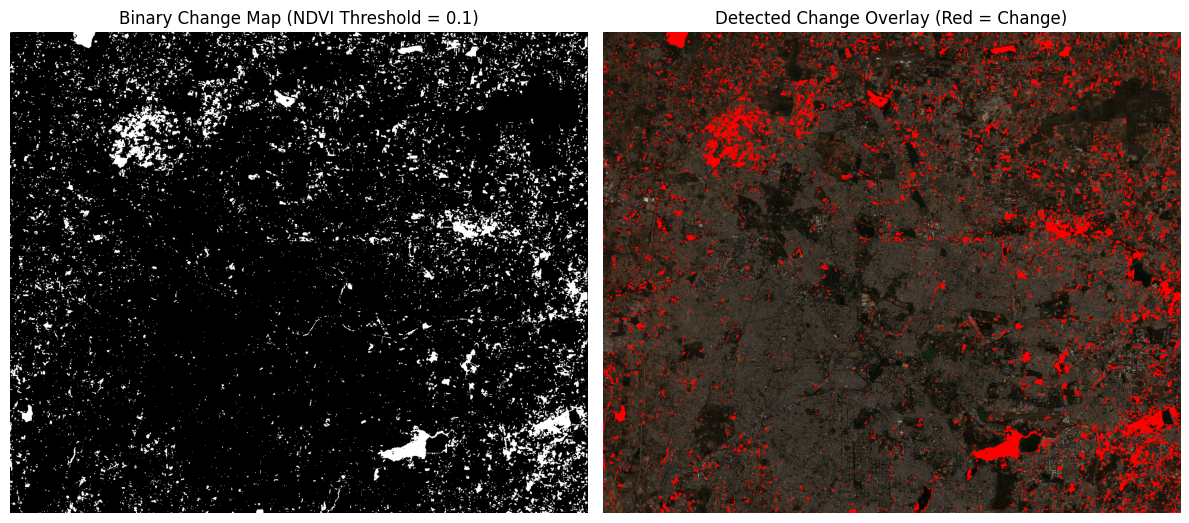

In [96]:
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

# -----------------------------
# Load RGB (reference grid)
# -----------------------------
with rasterio.open("bengaluru_2024_rgb.tif") as src:
    rgb = np.transpose(src.read([1, 2, 3]), (1, 2, 0))
    rgb_transform = src.transform
    rgb_crs = src.crs
    rgb_shape = src.height, src.width

rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

# -----------------------------
# Load NDVI change
# -----------------------------
with rasterio.open("bengaluru_ndvi_change.tif") as src:
    ndvi = src.read(1)
    ndvi_transform = src.transform
    ndvi_crs = src.crs

# -----------------------------
# Resample NDVI → RGB grid
# -----------------------------
ndvi_resampled = np.zeros(rgb_shape, dtype=np.float32)

reproject(
    source=ndvi,
    destination=ndvi_resampled,
    src_transform=ndvi_transform,
    src_crs=ndvi_crs,
    dst_transform=rgb_transform,
    dst_crs=rgb_crs,
    resampling=Resampling.bilinear
)

# -----------------------------
# Binary change mask
# -----------------------------
THRESH = 0.1
binary_change = (ndvi_resampled < -THRESH)

# -----------------------------
# Overlay (red = change)
# -----------------------------
overlay = rgb.copy()
overlay[binary_change] = [1, 0, 0]

# -----------------------------
# Plot
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(binary_change, cmap="gray")
axes[0].set_title("Binary Change Map (NDVI Threshold = 0.1)")
axes[0].axis("off")

axes[1].imshow(overlay)
axes[1].set_title("Detected Change Overlay (Red = Change)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


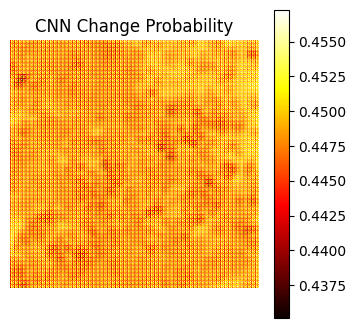

In [ ]:
plt.figure(figsize=(4,4))
plt.title("CNN Change Probability")
plt.imshow(pred, cmap="hot")
plt.colorbar()
plt.axis("off")
plt.show()


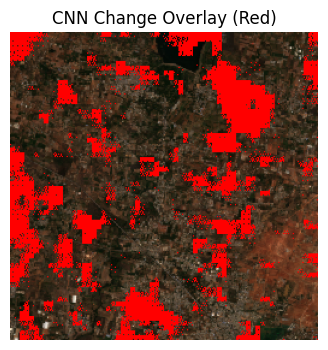

In [91]:
rgb = x2[0].permute(1,2,0).cpu().numpy()
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

overlay = rgb.copy()
overlay[binary == 1] = [1, 0, 0]

plt.figure(figsize=(4,4))
plt.imshow(overlay)
plt.title("CNN Change Overlay (Red)")
plt.axis("off")
plt.show()


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

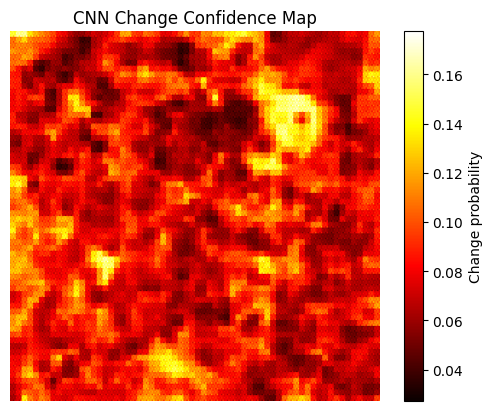

In [93]:
plt.imshow(pred_map, cmap="hot")
plt.colorbar(label="Change probability")
plt.title("CNN Change Confidence Map")
plt.axis("off")


In [101]:
# CNN output
# pred: (1, 1, 256, 256)
pred_tile = pred.detach().cpu().squeeze().numpy()   # (256, 256)

print(pred_tile.min(), pred_tile.max(), pred_tile.mean())


0.026807528 0.17597789 0.08048123


In [103]:
H, W = ndvi_resampled.shape

# Center crop coordinates
y0 = (H - 256) // 2
x0 = (W - 256) // 2

ndvi_tile = ndvi_resampled[y0:y0+256, x0:x0+256]

print(ndvi_tile.shape)


(256, 256)


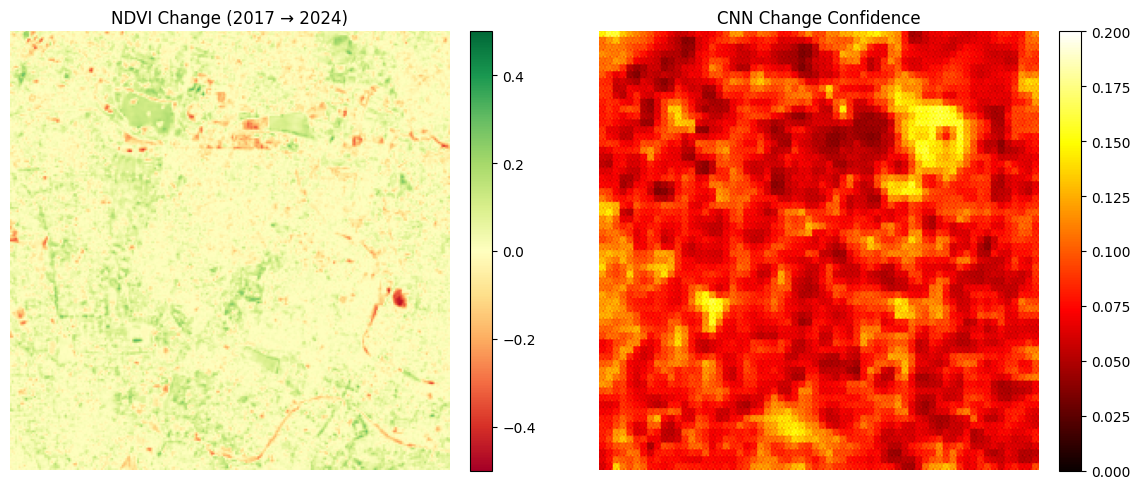

In [104]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# NDVI change map
im0 = axes[0].imshow(
    ndvi_tile,
    cmap="RdYlGn",
    vmin=-0.5,
    vmax=0.5
)
axes[0].set_title("NDVI Change (2017 → 2024)")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# CNN confidence map
im1 = axes[1].imshow(
    pred_tile,
    cmap="hot",
    vmin=0.0,
    vmax=0.2
)
axes[1].set_title("CNN Change Confidence")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [105]:
# pick a tile index that exists
tile_idx = 0   # change later if you want


In [106]:
import numpy as np
import matplotlib.pyplot as plt

# load tile data
x17 = np.load(f"dataset/train/img_2017/{tile_idx}.npy")
x24 = np.load(f"dataset/train/img_2024/{tile_idx}.npy")
mask = np.load(f"dataset/train/mask/{tile_idx}.npy")

# normalize RGB for plotting
x24_rgb = (x24 - x24.min()) / (x24.max() - x24.min())


In [107]:
ndvi_tile = mask.astype(float)
ndvi_tile[ndvi_tile == 0] = 0.0
ndvi_tile[ndvi_tile == 1] = -0.2   # vegetation loss proxy


In [108]:
import torch

model.eval()

with torch.no_grad():
    x1 = torch.tensor(x17).permute(2,0,1).unsqueeze(0).float().to(device)
    x2 = torch.tensor(x24).permute(2,0,1).unsqueeze(0).float().to(device)
    cnn_conf = model(x1, x2).squeeze().cpu().numpy()


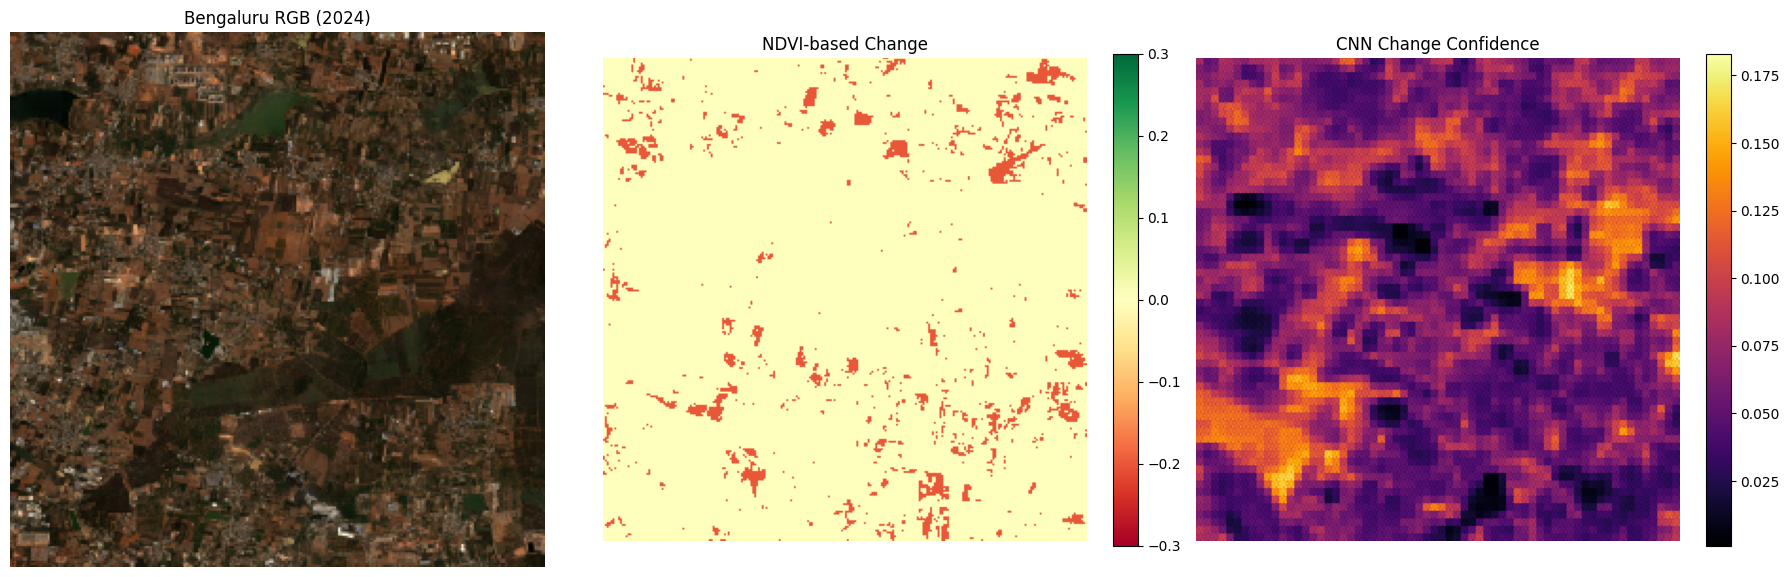

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. RGB
axes[0].imshow(x24_rgb)
axes[0].set_title("Bengaluru RGB (2024)")
axes[0].axis("off")

# 2. NDVI change
im1 = axes[1].imshow(ndvi_tile, cmap="RdYlGn", vmin=-0.3, vmax=0.3)
axes[1].set_title("NDVI-based Change")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# 3. CNN confidence
im2 = axes[2].imshow(cnn_conf, cmap="inferno")
axes[2].set_title("CNN Change Confidence")
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()
